<h1>Tuning LightGBM Model Hyperparameters with Optuna for House Price Prediction</h1>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# load data from a csv file
df = pd.read_csv('/content/sample_data/train.csv')
df = df.drop('Id', axis=1)
df_test = pd.read_csv('/content/sample_data/test.csv')

Mounted at /content/drive


In [3]:
# !pip install lightgbm
# !pip install optuna
# !pip install shap
import shap
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

<p> There are 20 features are selected, and they have int or float types. </p>

In [4]:
selected_columns = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1',
       'GarageCars', 'OverallCond', 'LotArea', 'YearRemodAdd', '1stFlrSF',
       'Fireplaces', 'GarageArea','OpenPorchSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'FullBath', 'HalfBath', 'MSSubClass', 'BedroomAbvGr', 'KitchenAbvGr', 'SalePrice']
df = df[selected_columns]
df_test = df_test[selected_columns[:-1]]

In [5]:
X, y = df.drop("SalePrice", axis=1), df["SalePrice"]

Optuna is a hyper-parameter optimization framework that automates the process of finding the best values for hyperparameters of a machine learning model. It is used to find the best values for hyperparameters that maximize the performance of a machine learning model on a given dataset.

This function defines the objective to optimize using Optuna. It trains and evaluates a LightGBM model on house price prediction task using 10-fold stratified cross-validation.

In [6]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'objective': 'regression', # Objective function
        'metric': 'rmse', # Evaluation metric
        'boosting_type': 'gbdt', # Type of boosting algorithm
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000), # Number of boosting iterations
        'num_leaves': trial.suggest_int('num_leaves', 20, 100), # Number of leaves in each decision tree
        'max_depth': trial.suggest_int("max_depth", 5, 50), # Maximum depth of each decision tree
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9), # Fraction of columns to be randomly sampled for each tree
        'subsample': trial.suggest_float('subsample', 0.7, 0.8), # Fraction of rows to be randomly sampled for each boosting iteration
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 5), # L1 regularization term
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 3), # L2 regularization term
        'min_child_weight': trial.suggest_float('min_child_weight', 2, 50), # Minimum sum of instance weight needed in a child
    }

    # Define cross-validation technique
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Initialize an empty list to store RMSE scores
    rmse_scores = []
    for train_idx, val_idx in cv.split(X, y):
        # Split the dataset into training and validation sets
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y[train_idx], y[val_idx]
        # Initialize a LightGBM Regressor model with the given hyperparameters
        model = lgb.LGBMRegressor(**params)

        # Fit the model on training data
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose = False)
        # Predict on validation set
        y_pred_val = model.predict(X_test)
        # Calculate RMSE score (Root Mean Square Error)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
        rmse_scores.append(rmse)

    # Calculate mean RMSE score across cross-validation folds
    mean_rmse = np.mean(rmse_scores)

    return mean_rmse


Creates an Optuna study object to search for the optimal hyperparameters for the LightGBM model using the objective function defined earlier. The objective function takes in the hyperparameters as input, trains the model with those hyperparameters using cross-validation, and returns the mean RMSE score. The study.optimize() function runs the optimization process for a specified number of trials, which is set to 20 in this case.

The best hyperparameters are then retrieved using the study.best_params attribute. Finally, a new LightGBM model is trained on the entire dataset (X and y) using the best hyperparameters obtained from the study. The resulting best_model can be used for making predictions on new data.

In [7]:
# Create Optuna study
study = optuna.create_study(direction='minimize')

# Optimize hyperparameters
study.optimize(objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X, y)

[I 2023-04-24 03:47:49,457] A new study created in memory with name: no-name-bdd9e83a-e038-4656-94ed-af6a1739917c
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.4296679023703591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4296679023703591
[LightGBM] [Warning] lambda_l2 is set=1.9729571689938634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9729571689938634


[I 2023-04-24 03:48:00,808] Trial 0 finished with value: 28730.975425994846 and parameters: {'n_estimators': 542, 'num_leaves': 42, 'max_depth': 22, 'learning_rate': 0.016795743391186835, 'colsample_bytree': 0.8428629654333036, 'subsample': 0.716820238597594, 'lambda_l1': 1.4296679023703591, 'lambda_l2': 1.9729571689938634, 'min_child_weight': 38.06204001707036}. Best is trial 0 with value: 28730.975425994846.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.3006290714264575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3006290714264575
[LightGBM] [Warning] lambda_l2 is set=0.5336672748891294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5336672748891294


[I 2023-04-24 03:48:07,089] Trial 1 finished with value: 29269.843600447195 and parameters: {'n_estimators': 508, 'num_leaves': 61, 'max_depth': 37, 'learning_rate': 0.07858383948555682, 'colsample_bytree': 0.6231524539269697, 'subsample': 0.7162948948933852, 'lambda_l1': 2.3006290714264575, 'lambda_l2': 0.5336672748891294, 'min_child_weight': 46.44270000121399}. Best is trial 0 with value: 28730.975425994846.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=1.55600055350199, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.55600055350199
[LightGBM] [Warning] lambda_l2 is set=0.6356392130806362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6356392130806362


[I 2023-04-24 03:48:17,891] Trial 2 finished with value: 28802.67418625956 and parameters: {'n_estimators': 822, 'num_leaves': 93, 'max_depth': 50, 'learning_rate': 0.010326602641123955, 'colsample_bytree': 0.7802739784177948, 'subsample': 0.74025044068777, 'lambda_l1': 1.55600055350199, 'lambda_l2': 0.6356392130806362, 'min_child_weight': 39.80098794861943}. Best is trial 0 with value: 28730.975425994846.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829
[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829
[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829
[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829
[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829
[LightGBM] [Warning] lambda_l1 is set=3.29554852846228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.29554852846228
[LightGBM] [Warning] lambda_l2 is set=1.531112082933829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.531112082933829


[I 2023-04-24 03:48:19,351] Trial 3 finished with value: 29081.89535633832 and parameters: {'n_estimators': 107, 'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.2222408386558134, 'colsample_bytree': 0.8421734735382377, 'subsample': 0.7611178266250623, 'lambda_l1': 3.29554852846228, 'lambda_l2': 1.531112082933829, 'min_child_weight': 34.667970080538886}. Best is trial 0 with value: 28730.975425994846.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.5917371605073413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5917371605073413
[LightGBM] [Warning] lambda_l2 is set=0.9824235393213951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9824235393213951


[I 2023-04-24 03:48:26,267] Trial 4 finished with value: 29587.27464340183 and parameters: {'n_estimators': 872, 'num_leaves': 31, 'max_depth': 11, 'learning_rate': 0.11144869120173684, 'colsample_bytree': 0.6763559355379338, 'subsample': 0.7083196196912133, 'lambda_l1': 0.5917371605073413, 'lambda_l2': 0.9824235393213951, 'min_child_weight': 47.03774579256801}. Best is trial 0 with value: 28730.975425994846.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.308690599354453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308690599354453
[LightGBM] [Warning] lambda_l2 is set=2.4071715470593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4071715470593


[I 2023-04-24 03:48:29,083] Trial 5 finished with value: 29056.67106763968 and parameters: {'n_estimators': 271, 'num_leaves': 63, 'max_depth': 46, 'learning_rate': 0.02122685074641951, 'colsample_bytree': 0.8693001451513387, 'subsample': 0.797770869217578, 'lambda_l1': 3.308690599354453, 'lambda_l2': 2.4071715470593, 'min_child_weight': 47.848043134008336}. Best is trial 0 with value: 28730.975425994846.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.45037456076757854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45037456076757854
[LightGBM] [Warning] lambda_l2 is set=1.9163129285499263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9163129285499263


[I 2023-04-24 03:48:36,697] Trial 6 finished with value: 28907.88679580969 and parameters: {'n_estimators': 917, 'num_leaves': 89, 'max_depth': 7, 'learning_rate': 0.018926393615997704, 'colsample_bytree': 0.6305830768896847, 'subsample': 0.791798009977906, 'lambda_l1': 0.45037456076757854, 'lambda_l2': 1.9163129285499263, 'min_child_weight': 47.01987081858936}. Best is trial 0 with value: 28730.975425994846.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.3065696573671177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3065696573671177
[LightGBM] [Warning] lambda_l2 is set=1.5518308894088562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5518308894088562


[I 2023-04-24 03:48:42,167] Trial 7 finished with value: 28597.975229325606 and parameters: {'n_estimators': 944, 'num_leaves': 38, 'max_depth': 7, 'learning_rate': 0.040849755411382034, 'colsample_bytree': 0.617695664527441, 'subsample': 0.7068645523211731, 'lambda_l1': 3.3065696573671177, 'lambda_l2': 1.5518308894088562, 'min_child_weight': 29.22496505126758}. Best is trial 7 with value: 28597.975229325606.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument inst

[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662
[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662
[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662
[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662
[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
[I 2023-04-24 03:48:44,126] Trial 8 finished with value: 34881.78180777956 and parameters: {'n_estimators': 156, 'num_leaves': 44, 'max_depth': 36, 'learning_rate': 0.010926038441898872, 'colsample_bytree': 0.7968007688915609, 'subsample': 0.725340373288514, 'lambda_l1': 2.854244334957767, 'lambda_l2': 2.351574513468662, 'min_child_weight': 29.867363888317318}. Best is trial 7 with value: 28597.975229325606.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] lambda_l1 is set=2.854244334957767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854244334957767
[LightGBM] [Warning] lambda_l2 is set=2.351574513468662, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.351574513468662


The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=0.9830188692042108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9830188692042108
[LightGBM] [Warning] lambda_l2 is set=1.4592507547033629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4592507547033629


[I 2023-04-24 03:48:56,108] Trial 9 finished with value: 28299.339550490266 and parameters: {'n_estimators': 780, 'num_leaves': 32, 'max_depth': 32, 'learning_rate': 0.010327810811826063, 'colsample_bytree': 0.7067218308627243, 'subsample': 0.7937265537557316, 'lambda_l1': 0.9830188692042108, 'lambda_l2': 1.4592507547033629, 'min_child_weight': 6.044630112000712}. Best is trial 9 with value: 28299.339550490266.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.475609043670212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.475609043670212
[LightGBM] [Warning] lambda_l2 is set=0.17331525873612907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17331525873612907


[I 2023-04-24 03:49:03,015] Trial 10 finished with value: 28098.61837102964 and parameters: {'n_estimators': 645, 'num_leaves': 21, 'max_depth': 22, 'learning_rate': 0.03746140700355959, 'colsample_bytree': 0.5004685600165342, 'subsample': 0.7759069786997025, 'lambda_l1': 4.475609043670212, 'lambda_l2': 0.17331525873612907, 'min_child_weight': 4.108357927169521}. Best is trial 10 with value: 28098.61837102964.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


[I 2023-04-24 03:49:08,887] Trial 11 finished with value: 28017.287584230042 and parameters: {'n_estimators': 657, 'num_leaves': 20, 'max_depth': 25, 'learning_rate': 0.03831625680598642, 'colsample_bytree': 0.503133429155677, 'subsample': 0.7767407900638205, 'lambda_l1': 4.963452788988035, 'lambda_l2': 0.006699347792185062, 'min_child_weight': 3.3870950442913017}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.932799898801142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932799898801142
[LightGBM] [Warning] lambda_l2 is set=0.27482546022310855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27482546022310855


[I 2023-04-24 03:49:13,783] Trial 12 finished with value: 28322.320327372006 and parameters: {'n_estimators': 596, 'num_leaves': 20, 'max_depth': 21, 'learning_rate': 0.04554723473125056, 'colsample_bytree': 0.5130282387846522, 'subsample': 0.7740870883957757, 'lambda_l1': 4.932799898801142, 'lambda_l2': 0.27482546022310855, 'min_child_weight': 2.255628058828708}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.875162043479842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.875162043479842
[LightGBM] [Warning] lambda_l2 is set=0.009869137925743399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009869137925743399


[I 2023-04-24 03:49:22,421] Trial 13 finished with value: 28046.16263666043 and parameters: {'n_estimators': 678, 'num_leaves': 21, 'max_depth': 20, 'learning_rate': 0.03606950046971728, 'colsample_bytree': 0.5013178828216265, 'subsample': 0.7714515560950548, 'lambda_l1': 4.875162043479842, 'lambda_l2': 0.009869137925743399, 'min_child_weight': 11.194922976021475}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.274173490365461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.274173490365461
[LightGBM] [Warning] lambda_l2 is set=0.08127950161162471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08127950161162471


[I 2023-04-24 03:49:30,606] Trial 14 finished with value: 28399.64399121661 and parameters: {'n_estimators': 712, 'num_leaves': 52, 'max_depth': 14, 'learning_rate': 0.029604581800238904, 'colsample_bytree': 0.5477948968339369, 'subsample': 0.7559433495054977, 'lambda_l1': 4.274173490365461, 'lambda_l2': 0.08127950161162471, 'min_child_weight': 12.627310932407395}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.989749338165982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.989749338165982
[LightGBM] [Warning] lambda_l2 is set=0.7308196481735233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7308196481735233


[I 2023-04-24 03:49:37,897] Trial 15 finished with value: 28620.877811829403 and parameters: {'n_estimators': 364, 'num_leaves': 79, 'max_depth': 29, 'learning_rate': 0.06506615286627089, 'colsample_bytree': 0.5666829189565752, 'subsample': 0.7732582118474096, 'lambda_l1': 4.989749338165982, 'lambda_l2': 0.7308196481735233, 'min_child_weight': 16.470622480692697}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.095926305193354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.095926305193354
[LightGBM] [Warning] lambda_l2 is set=0.05388083230371121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05388083230371121


[I 2023-04-24 03:49:42,183] Trial 16 finished with value: 28250.02957491832 and parameters: {'n_estimators': 437, 'num_leaves': 27, 'max_depth': 16, 'learning_rate': 0.02815537094091735, 'colsample_bytree': 0.5549212760631826, 'subsample': 0.7478714465312585, 'lambda_l1': 4.095926305193354, 'lambda_l2': 0.05388083230371121, 'min_child_weight': 19.09640804139018}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.050014971863287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.050014971863287
[LightGBM] [Warning] lambda_l2 is set=0.3867466519542383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3867466519542383


[I 2023-04-24 03:49:54,540] Trial 17 finished with value: 28077.996573764365 and parameters: {'n_estimators': 703, 'num_leaves': 74, 'max_depth': 25, 'learning_rate': 0.057057186629069265, 'colsample_bytree': 0.504215157959859, 'subsample': 0.7829696268779318, 'lambda_l1': 4.050014971863287, 'lambda_l2': 0.3867466519542383, 'min_child_weight': 11.503023921385317}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=4.5889254409214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5889254409214
[LightGBM] [Warning] lambda_l2 is set=2.953229854259559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.953229854259559


[I 2023-04-24 03:50:00,569] Trial 18 finished with value: 28665.303542198097 and parameters: {'n_estimators': 425, 'num_leaves': 50, 'max_depth': 17, 'learning_rate': 0.07862556086542145, 'colsample_bytree': 0.5878757847812739, 'subsample': 0.76474278004164, 'lambda_l1': 4.5889254409214, 'lambda_l2': 2.953229854259559, 'min_child_weight': 21.135065474505023}. Best is trial 11 with value: 28017.287584230042.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The least populated class in y has only 1 members, which is less than n_splits=10.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] lambda_l1 is set=3.8763103029165795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8763103029165795
[LightGBM] [Warning] lambda_l2 is set=0.010599727373254764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010599727373254764


[I 2023-04-24 03:50:12,321] Trial 19 finished with value: 28290.960010004008 and parameters: {'n_estimators': 989, 'num_leaves': 28, 'max_depth': 29, 'learning_rate': 0.03042233329266553, 'colsample_bytree': 0.5381235221629627, 'subsample': 0.7841111251625502, 'lambda_l1': 3.8763103029165795, 'lambda_l2': 0.010599727373254764, 'min_child_weight': 10.323878397396488}. Best is trial 11 with value: 28017.287584230042.


[LightGBM] [Warning] lambda_l1 is set=4.963452788988035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.963452788988035
[LightGBM] [Warning] lambda_l2 is set=0.006699347792185062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006699347792185062


LGBMRegressor(colsample_bytree=0.503133429155677, lambda_l1=4.963452788988035,
              lambda_l2=0.006699347792185062, learning_rate=0.03831625680598642,
              max_depth=25, min_child_weight=3.3870950442913017,
              n_estimators=657, num_leaves=20, subsample=0.7767407900638205)

In [8]:
print(study.best_value)

28017.287584230042



<h1>Explain the model's predictions on the entire dataset<h1>
<h2>What is SHAP?</h2>
<h4>SHAP (SHapley Additive exPlanations) is a method used in machine learning to explain the predictions made by a model. It provides a way to attribute a prediction to different input variables or features, by deconstructing the prediction into contributions from each input variable. SHAP values are based on cooperative game theory and provide a fair way to allocate the prediction's value to the individual input variables, considering their interactions and dependencies. SHAP values can help interpret the decision-making process of machine learning models and understand the relative importance of different features in making predictions.</h4>

<h2>SHAP Summary Plot</h2>
<h4>It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in house price prediction.</h4>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


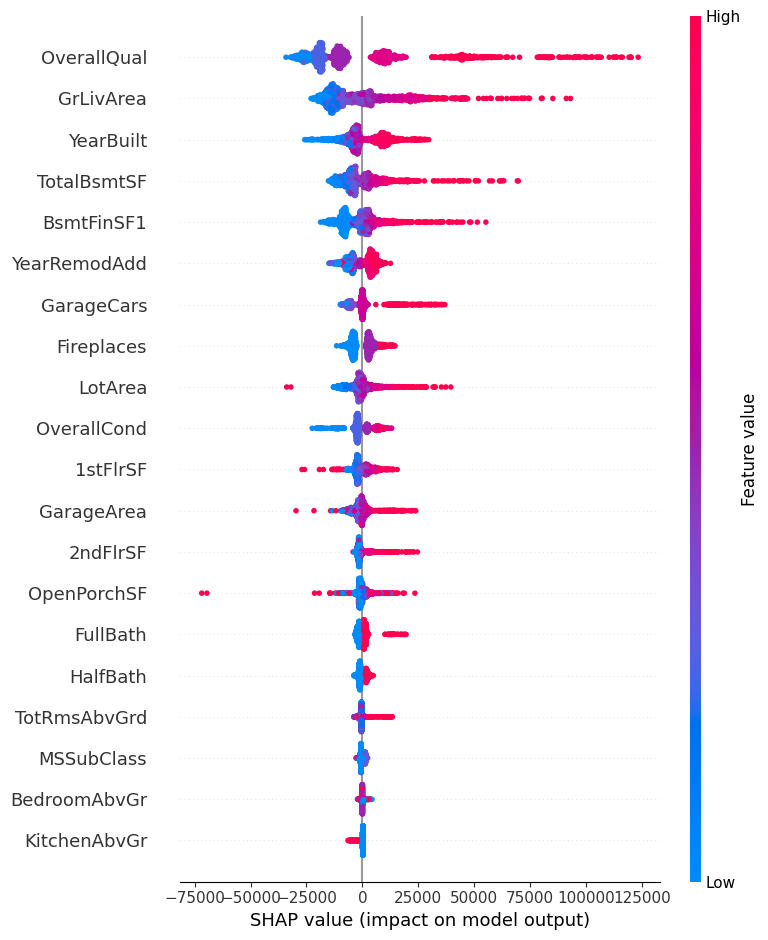

In [ ]:
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X)

<h2>SHAP Interaction Value Summary Plot</h2>
<h4>A SHAP Interaction Value Summary Plot is a graphical representation that shows a matrix of summary plots, where the main effects of features are displayed on the diagonal, and the interaction effects between pairs of features are shown off the diagonal.</h4>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


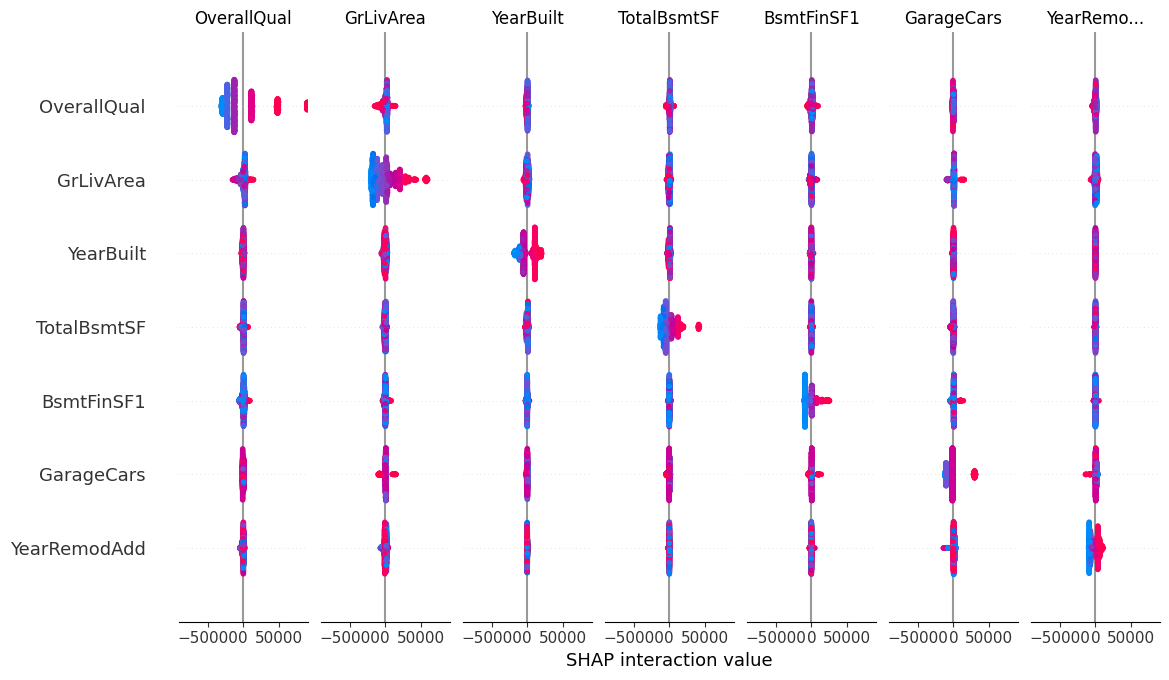

In [ ]:
shap_interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(X.iloc[:,:])
shap.summary_plot(shap_interaction_values, X.iloc[:,:])

Predict on test data

In [ ]:
predictLGBM = best_model.predict(df_test)
submissionLGBM = pd.DataFrame({'SalePrice':predictLGBM})
display(submissionLGBM.head())
# print(submissionLGBM.iloc[0].values)

,SalePrice
0,127368.782722
1,156700.928621
2,180422.435175
3,183877.895502
4,186021.015175
